Major improvement from v2 to v3 - More efficient handling of false collisions.  In v2, all walls reported ONE smallest positive time and we used the smallest of these.  If it resulted in a false collision, we simply didn't apply collision map or record state and move to the next step.  However, this re-computes all dt's again in next step.  This is wasteful.

In v3, all walls report ALL postitive times.  We try them from smallest to largest until we find one that gives a real collision.  This avoids re-computing dt's due to false collisions.

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tol = 1e-4

class Wall():
    def specular_law(self, part, state_history):
        n = self.get_normal(part)
        part.vel -= 2 * (n@part.vel) * n
        return part.vel
        
        
    def wrap_law(self, part, state_history):
        if wrap_wall_idx is None:
            raise Exception("Must specify wrap_wall to use wrap_law")
        part.phi = np.nan
        state_history = record_state(part, state_history)  # record in the existing state_history
        part.arclength = np.nan

        old = self.wall_idx
        new = self.wrap_wall_idx
        part.wall_idx = new
        part.wrap_count[old] += 1
        part.wrap_count[new] -= 1
        
        F_old = self.axes.T
        F_new = Walls[new].axes.T

        dx_old = self.base - part.pos
        dx_frame_old = dx_old @ F_old
        dx_frame_new = dx_frame_old.copy()
        dx_frame_new[0] *= -1
        if self.flip_pos:
            dx_frame_new[1] *= -1
        dx_new = F_new @ dx_frame_new
        part.pos = Walls[new].base + dx_new

        dv_frame_old = part.vel @ F_old
        dv_frame_new = dv_frame_old.copy()
        dv_frame_new[0] *= -1
        if self.flip_vel:
            dv_frame_new[1] *= -1
        part.vel = F_new @ dv_frame_new
        
        
    def assign_law(self):
        if self.collision_law_name == "specular":
            self.resolve_collision = self.specular_law
        elif self.collision_law_name == "wrap":
            if self.wall_type != 'flat':
                raise Exception('Wrap only defined for flat walls')
            if self.hard:
                make_soft = input("Wall assigned wrap wall and hard=True.  Particle will stop before the wall and jump to wrap wall.  Do you want me to make it a soft wall (y/n)?")
                if make_soft in ['y', 'Y', 'yes', 'YES', 'Yes']:
                    self.hard = False
            self.resolve_collision = self.wrap_law

            
    def extend_ONB(self, A):
        A = np.asarray(A)
        if A.ndim == 0:
            return np.eye(self.dim)
        if A.ndim == 1:
            A = A[:,np.newaxis]
        m, n = A.shape
        if m <= n:
            A = A.T
            m, n = n, m
        F = np.linalg.qr(A, 'complete')[0].T
        s = np.sign(F@A)
        F[:n] *= np.diag(s).reshape(-1,1)
        return F

           
    def cap_endpoints(self, Walls):
        bdy_pts = self.get_bdy_pts().T
        normal = bdy_pts[0] - bdy_pts[1]
        new_wall = SphereWall(base=bdy_pts[0], radius=0.0, axes=[normal],
                              max_polar_angle=np.pi/2*1.01, outside=True, inside=False)
        Walls.append(new_wall)
        
        normal = bdy_pts[-1] - bdy_pts[-2]
        new_wall = SphereWall(base=bdy_pts[-1], radius=0.0, axes=[normal],
                              max_polar_angle=np.pi/2*1.01, outside=True, inside=False)
        Walls.append(new_wall)
        return Walls

        
class FlatWall(Wall):
    def __init__(self, base, length, axes=None, collision_law="specular", 
                 hard=True, two_sided=False,
                 wrap_wall_idx=None, flip_pos=False, flip_vel=False):
        self.wall_type = 'flat'
        self.collision_law_name = collision_law
        self.base = np.array(base)
        self.dim = len(self.base)
        self.two_sided = two_sided
        self.hard = hard
        self.length = length
        self.total_arclength = 2 * self.length
        if self.two_sided:
            self.total_arclength *= 2
        
        self.axes = self.extend_ONB(axes)
        self.normal = self.axes[0]
        self.tangent = self.axes[1:]
        
        self.wrap_wall_idx = wrap_wall_idx
        self.flip_pos = flip_pos
        self.flip_vel = flip_vel
        self.assign_law()

    def get_normal(self, part):
        return self.normal

    def get_frame(self, part):
        return self.axes

    def get_dt(self, part):
        c1 = part.vel @ self.normal
        if abs(c1) < tol:
            self.dt = []
        else:
            dx = self.base - part.pos
            dx_normal = dx @ self.normal
            T = []
            r = part.radius * self.hard
            for R in {r, -r}:
                c0 = dx_normal - R
                T.append(c0 / c1)
            if len(T) == 0:
                self.dt = []
            else:
                self.dt = np.array(T)
                if self.wall_idx == part.wall_idx:
                    idx = np.argmin(np.abs(self.dt))
                    self.dt[idx] = np.inf
                idx = (self.dt < 0)
                self.dt[idx] = np.inf
        return self.dt

                
    def check_real_collision_get_arclength(self, part):
        if self.wall_idx < part.wall_idx:
            self.arclength = self.total_arclength
        elif self.wall_idx > part.wall_idx:
            self.arclength = 0
        else:
            dx = self.base - part.pos
            F = self.axes.T
            dx_frame = dx @ F
            if np.abs(dx_frame[1]) > self.length:
                self.arclength = -np.inf
            else:
                self.arclength = dx_frame[1] + self.length
                
            if self.two_sided and dx_frame[0] >= 0:
                self.arclength += self.total_arclength / 2
        return self.arclength
    
    
    def get_bdy_pts(self):
        try:  # returns bdy_pts if previously computed
            return self.bdy_pts
        except:
            s = np.linspace(-self.length, self.length, 100)
            self.bdy_pts = (self.base + self.tangent * s[:,np.newaxis]).T
            return self.bdy_pts

                
class SphereWall(Wall):
    def __init__(self, base, radius, axes=None, max_polar_angle=np.pi,
                 collision_law="specular", wrap_wall_idx=None, hard=True,
                 inside=False, outside=False):
        self.wall_type = 'sphere'
        self.collision_law_name = collision_law
        self.base = np.array(base)
        self.dim = len(self.base)
        self.hard = hard
        self.radius = radius
        self.axes = self.extend_ONB(axes)
        assert 0 <= max_polar_angle <= np.pi, f"max_polar_angle must lie between 0 and pi; got {max_polar_angle}"
        self.max_polar_angle = max_polar_angle
        self.max_normal_projection = -np.cos(max_polar_angle)
        self.hole_radius = self.radius * np.sin(np.pi - self.max_polar_angle)
        self.two_sided = (self.hole_radius> part.radius)
        if self.two_sided:
            self.inside = True
            self.outside = True
        else:
            self.inside = inside
            self.outside = outside
            assert self.inside or self.outside, f"At least one of inside or outside must be explicitly set True because hole is too small for particle to pass through."
                
        self.inside_arclength = 2 * self.max_polar_angle * self.inside * (self.radius - part.radius * self.hard)
        self.outside_arclength = 2 * self.max_polar_angle * self.outside * (self.radius + part.radius * self.hard)
        self.total_arclength = self.inside_arclength + self.outside_arclength
        self.wrap_wall_idx = wrap_wall_idx
        self.assign_law()
    
    
    def get_normal(self, part):
        dx = self.base - part.pos
        return dx / np.linalg.norm(dx)
    
    
    def get_frame(self, part):
        n = self.get_normal(part)
        return self.extend_ONB(n)

    
    def get_dt(self, part):
        dx = self.base - part.pos
        dv = part.vel
        c2 = dv @ dv
        c1 = -2 * dx @ dv
        
        T = []
        r = part.radius * self.hard
        for R in {self.radius + r, self.radius - r}:
            if R < 0:
                continue
            c0 = dx @ dx - R**2
            if abs(c2) < tol:
                if abs(c1) > tol:
                    t = c0 / c1
                    T.append(t)
            else:
                d = c1**2 - 4 * c2 * c0
                if d >= 0:
                    s = np.sqrt(d)
                    T.append((-c1 + s) / (2 * c2))
                    T.append((-c1 - s) / (2 * c2))
        if len(T) == 0:
            self.dt = [np.inf]
        else:
            self.dt = np.array(T)
            if self.wall_idx == part.wall_idx:
                idx = np.argmin(np.abs(self.dt))
                self.dt[idx] = np.inf
            idx = (self.dt < 0)
            self.dt[idx] = np.inf
        return self.dt

    
    def check_real_collision_get_arclength(self, part):
        if self.wall_idx < part.wall_idx:
            self.arclength = self.total_arclength
        elif self.wall_idx > part.wall_idx:
            self.arclength = 0
        else:
            dx = self.base - part.pos
            mag = np.linalg.norm(dx)
            dx /= mag
            F = self.axes.T
            dx_frame = dx @ F
            if dx_frame[0] > self.max_normal_projection:
                self.arclength = -np.inf
            else:
                polar_angle = (np.pi - np.arccos(dx_frame[0])) * np.sign(dx_frame[1])
                if mag < self.radius:
                    self.arclength = (polar_angle + self.max_polar_angle) * (self.radius - part.radius * self.hard)
                else:
                    self.arclength = (polar_angle + self.max_polar_angle) * (self.radius + part.radius * self.hard)
                    self.arclength += self.inside_arclength
        return self.arclength
        

    def get_bdy_pts(self):
        try:
            return bdy_pts
        except:
            s = np.linspace(-self.max_polar_angle, self.max_polar_angle, 100)
            self.bdy_pts = np.array([np.cos(s), np.sin(s)]) * self.radius
            self.bdy_pts = self.axes.T @ self.bdy_pts
            self.bdy_pts += self.base[:,np.newaxis]
            return self.bdy_pts
                
            
class Particle():
    def __init__(self, dim=2, radius=1, mass=1, gamma=1/np.sqrt(2)):
        self.dim = dim
        self.radius = radius
        self.mass = mass
        self.gamma = gamma
        self.inertia = self.mass * self.gamma * self.radius**2


    def get_bdy_pts(self):
        try:
            return self.bdy_pts
        except:
            s = np.linspace(-np.pi, np.pi, 100)
            s = np.append(s, 0)
            self.bdy_pts = self.radius * np.array([np.cos(s), np.sin(s)])
            return self.bdy_pts


    def check_real_collision_get_arclength(self):
        arclengths = [wall.check_real_collision_get_arclength(self) for wall in Walls]
        self.arclength = np.sum(arclengths)
        if self.arclength >= 0:
            self.real_collision = True
        else:
            self.real_collision = False
            self.arclength = np.nan
        return self.real_collision

    
    def get_phi(self):
        F = Walls[self.wall_idx].get_frame(self).T
        dv = part.vel / np.linalg.norm(part.vel)
        dv_frame = dv @ F
        self.phi = np.arccos(abs(dv_frame[0])) * np.sign(dv_frame[1])
        return self.phi


    
def initialize(part, Walls):
    for i in range(len(Walls)):
        Walls[i].wall_idx = i
   
    start_wall = Walls[polygon_sides]
    part.wall_idx = start_wall.wall_idx

    # particle's initial position will be against the scatterer at angle theta to the positive x-axis
    theta = np.random.rand() * np.pi / 4  
    part.pos = np.array([np.cos(theta), np.sin(theta)]) * (part.radius + start_wall.radius)


    # particle's initial velocity will be at angle phi to the normal vector at intial position
    a = np.random.rand()  # between 0 and 1
    a = 2*a - 1  # between -1 and +1
#     phi =  a * np.pi / 2  #between -pi/2 and +pi/2
    phi =  np.arcsin(a)  # Follows the cosine law, the invariant measure for the billiard map


    # Now, we need to get a normal vector to the scatterer at intitial position.
    n = -1*start_wall.get_normal(part)


    # Now, we want to rotate it by angle phi.  So, create the rotation matrix.
    R = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]
                 ])

    # Apply it to n
    part.vel = R@n
    part.spin = 1.0
    
    part.t = 0
    part.check_real_collision_get_arclength()
    part.get_phi()
    part.wrap_count = np.zeros(len(Walls), int)
    return part, Walls


def run(part, Walls):
    state_history = record_state(part)  # creates state_history because we didn't pass in state_history

    for i in range(steps):
    #     print(f"step {i}")

        part, Walls = next_state(part, Walls, state_history)  # evolves the system forward one step
        state_history = record_state(part, state_history)  # record in the existing state_history

    new = {}
    for key, val in state_history.items():
        new[key] = np.array(val)

    return new

In [0]:
from copy import deepcopy
from IPython.display import HTML
from matplotlib import animation, rc
import io
import base64

def interpolate(state_history, frame_count):
    pos = state_history['POS']
    t   = state_history['T']
    
    dist = np.linalg.norm(pos, axis=-1)
    cum_dist = np.cumsum(dist)
    
    max_flight = np.linalg.norm(np.ptp(pos, axis=0))
    max_flight_frame = max_flight / 25
    max_cum_dist = max_flight_frame * frame_count
    idx = cum_dist < max_cum_dist
    
    pos = pos[idx]
    t   = t[idx] - t[0]
    vel = state_history['VEL'][idx]
    spin = state_history['SPIN'][idx]
    
    dt_frame_ave = t[-1] / frame_count
    dt_collision = np.diff(t)
    frames_interp = np.ceil(dt_collision / dt_frame_ave).astype(int)
    frames_interp[frames_interp < 1] = 1
    
    dt = np.append(dt_collision / frames_interp, 0)

    def interp(x):
        x_interp = np.repeat(x[:-1], frames_interp, axis=0)    
        x_interp = np.append(x_interp, x[[-1]], axis=0)
        return x_interp
    
    state_history_interp = deepcopy(state_history)
    state_history_interp['DT'] = np.hstack([dt * np.arange(f) for dt, f in zip(dt, frames_interp)]+[0])
    state_history_interp['T']   = interp(t) + state_history_interp['DT']
    state_history_interp['VEL'] = interp(vel)
    state_history_interp['SPIN'] = interp(spin)
    state_history_interp['POS'] = interp(pos)
    state_history_interp['POS']+= state_history_interp['VEL'] * state_history_interp['DT'][:,np.newaxis]

    drot = interp(spin) * interp(dt)
    drot = np.insert(drot[:-1], 0, 0)
    rot = 0 + np.cumsum(drot)
    state_history_interp['ROT'] = np.moveaxis(np.array([[np.cos(rot), -np.sin(rot)],[np.sin(rot), np.cos(rot)]]),-1,0)   
    state_history_interp['interpolated'] = True
    return state_history_interp


def embed_video(fname):
    video = io.open(fname, 'r+b').read()
    encoded = base64.b64encode(video)

    display(HTML(data='''<video alt="test" controls>
         <source src="data:video/mp4;base64,{0}" type="video/mp4" />
         </video>'''.format(encoded.decode('ascii'))))

    
def animate(state_history, movie_time=10, frame_rate=60, show_trails=True,
           save=False, embed=True):
    interp_only = not (save or embed)
    if interp_only:
        print("Only doing interpolation because both save and embed are false.")
    
    frame_count = movie_time * frame_rate
    print(f"I will attempt to animate {frame_count} frames")
    
    state_history_interp = interpolate(state_history, frame_count)
    
    t = state_history_interp['T']
    pos = state_history_interp['POS']
    rot = state_history_interp['ROT']
    dt = np.abs(np.diff(t))
    steps = len(dt)
    big_steps = np.nonzero(dt > tol)[0].tolist()
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_facecolor('w')
    
    for wall in Walls:
        ax.plot(*wall.get_bdy_pts(), 'k', linewidth=3.0)

    time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes)
    bdy_pts = part.get_bdy_pts()
    bdy = ax.plot([],[], 'r', linewidth=1.0)[0]
    
    trails = []
    for i in range(steps):
        trails.append(ax.plot(pos[i:i+2,0], pos[i:i+2,1], 'g:', alpha=0.0)[0])
    
    def init():
        time_text.set_text('')
        bdy.set_data(rot[0] @ bdy_pts + pos[[0]].T)
        return [bdy] + trails


    def update(s):
        time_text.set_text(f"time {t[s]:.2f}")
        bdy.set_data(rot[s] @ bdy_pts + pos[[s]].T)
        if show_trails:
            for i in big_steps:
                if i >= s:
                    break
                trails[i].set_alpha(1.0)
        return [bdy] + trails
    anim = animation.FuncAnimation(fig, update, init_func=init,
                                   frames=frame_count, interval=movie_time*1000/frame_count, 
                                   blit=True)
    plt.close()

    if save:
        anim_filename = 'animation.mp4'
        try:
            anim.save(filename=anim_filename)    # save animation as mp4
        except:
            install = input("First animation attempt failed.  Shall I try to install ffmpeg and try again (y/n)?")
            if install in ['y', 'Y', 'yes', 'Yes', 'YES']:
                os.system('add-apt-repository ppa:mc3man/trusty-media ')
                os.system('apt-get update')
                os.system('apt-get install --upgrade ffmpeg')
                os.system('apt-get install --upgrade frei0r-plugins')
                anim.save(filename=anim_filename)    # save animation as mp4
            else:
                print("OK, I give up.  Returning the anim object.")
                return anim
        if embed:
            embed_video(anim_filename)    # show in notebook - resizing issues
    elif embed:
        display(HTML(anim.to_jshtml()))        # diplays video in notebook

    return state_history_interp, anim

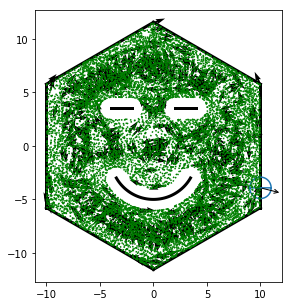

I will attempt to animate 200 frames


In [0]:
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 5000
dim = 2

part = Particle(radius=1.0)

Walls = []
polygon_sides = 6
polygon_radius_inscribed = 10
assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
offset = int(polygon_sides / 2)

length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
    v = np.array([np.cos(theta), np.sin(theta)])
    b = v * polygon_radius_inscribed
    n = -1 * v
    t = [n[1], -n[0]]
    axes = [n, t]
    wrap_wall_idx = (i + offset) % polygon_sides
    new_wall = FlatWall(base=b, axes=axes, length=length, collision_law='wrap',
                        wrap_wall_idx=wrap_wall_idx, hard=False, flip_vel=True)
    Walls.append(new_wall)


scatterer_radius = 4
assert (scatterer_radius < polygon_radius_inscribed), "scatterer won't fit in the polygon"  # checks that the scatterer fits
new_wall = SphereWall(base=[0.0, -1.0], radius=scatterer_radius, max_polar_angle = np.pi/3,
                      axes=[[0,-1],[1,0]])
Walls.append(new_wall)
if new_wall.max_polar_angle < np.pi:
    new_wall.cap_endpoints(Walls)


new_wall = FlatWall(base=[-3.0,3.5], axes=[0,1], length=1, two_sided=True)#, hard=False)
Walls.append(new_wall)
new_wall.cap_endpoints(Walls)

new_wall = FlatWall(base=[3.0,3.51], axes=[0,1], length=1, two_sided=True)#, hard=False)
Walls.append(new_wall)
new_wall.cap_endpoints(Walls)


part, Walls = initialize(part, Walls)

%run -i dynamics
state_history = run(part, Walls)

ax = draw(state_history, Walls, stop_step=1000)
plt.show()

state_history_interp, anim = animate(state_history, movie_time=10, frame_rate=20, show_trails=True, save=True)

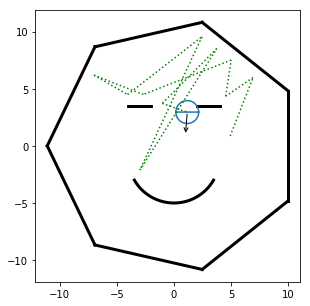

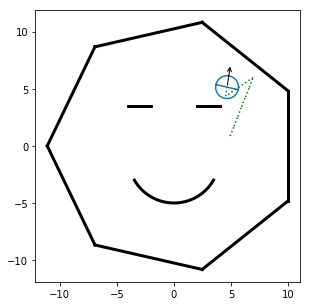

In [0]:
#@title Interactive {run: "auto"}
plot_steps =11 #@param {type:"slider", min:0, max:50, step:1}

ax = draw(state_history, Walls, stop_step=plot_steps+1, arrows=False)
plt.show()

ax = draw(state_history_interp, Walls, stop_step=plot_steps+1, arrows=False)
plt.show()

<Figure size 432x288 with 0 Axes>

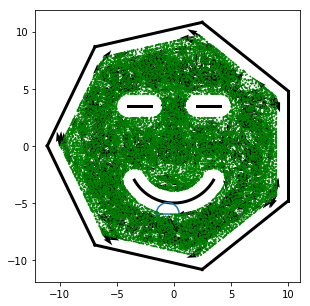

I will attempt to animate 200 frames


In [0]:
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 50000
dim = 2

part = Particle(radius=1.0)

Walls = []
polygon_sides = 7
polygon_radius_inscribed = 10
scatterer_radius = 4
assert (scatterer_radius < polygon_radius_inscribed), "scatterer won't fit in the polygon"  # checks that the scatterer fits


length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
    v = np.array([np.cos(theta), np.sin(theta)])
    b = v * polygon_radius_inscribed
    n = -1 * v
    t = [n[1], -n[0]]
    axes = [n, t]
    new_wall = FlatWall(base=b, axes=axes, length=length)
    Walls.append(new_wall)


new_wall = SphereWall(base=[0.0, -1.0], radius=scatterer_radius, max_polar_angle = np.pi/3, axes=[[0,-1],[1,0]])
Walls.append(new_wall)
if new_wall.max_polar_angle < np.pi:
    new_wall.cap_endpoints(Walls)

    
new_wall = FlatWall(base=[-3.0,3.5], axes=[0,1], length=1, two_sided=True)#, hard=False)
Walls.append(new_wall)
new_wall.cap_endpoints(Walls)

new_wall = FlatWall(base=[3.0,3.51], axes=[0,1], length=1, two_sided=True)#, hard=False)
Walls.append(new_wall)
new_wall.cap_endpoints(Walls)


part, Walls = initialize(part, Walls)

%run -i dynamics
state_history = run(part, Walls)

ax = draw(state_history, Walls, stop_step=1000)
plt.show()

state_history_interp, anim = animate(state_history, movie_time=10, frame_rate=20, show_trails=True, save=True)

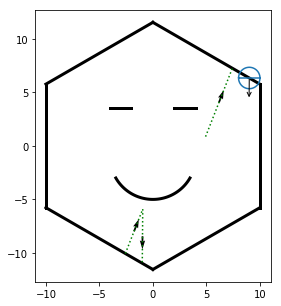

In [0]:
#@title Interactive {run: "auto"}
plot_steps =5 #@param {type:"slider", min:0, max:50, step:1}

ax = draw(state_history, Walls, stop_step=plot_steps+1, arrows=False)
plt.show()

ax = draw(state_history_interp, Walls, stop_step=plot_steps+1, arrows=False)
plt.show()

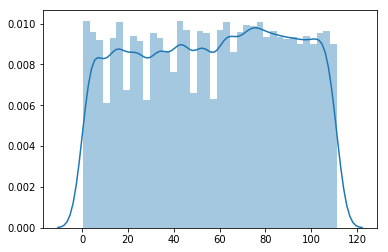

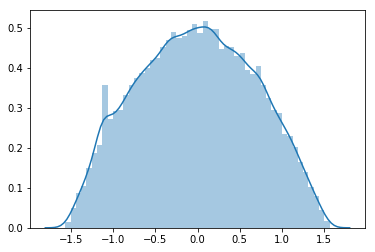

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
arc = state_history['ARCLENGTH'].copy()
arc = arc[~np.isnan(arc)]
sns.distplot(arc)
plt.show()

phi = state_history['PHI'].copy()
phi = phi[~np.isnan(phi)]
sns.distplot(phi)
plt.show()